Identifying Key Protein Pairs

In [48]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import linkage, dendrogram
from scipy.spatial.distance import squareform
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
import networkx as nx
from mpl_toolkits.axes_grid1 import make_axes_locatable
import os

df_cell = pd.read_csv('/Users/22holleranm/DATA_481_766_protein_networks/shared_team_files/lung_cancer.csv', index_col=0)

In [49]:
# Step 1: create a new dataframe with nuclear protein values only
# extract columns with nuclear measurements
nuclear_cols = [col for col in df_cell.columns if 'nuc_mean' in col]
df_nuclear = df_cell[nuclear_cols].copy()

# simplify column names by removing the location and measurement type
df_nuclear.columns = [col.split('_')[1] for col in df_nuclear.columns]

In [ ]:
# descriptive so setup is easily reproducible [MHM]
# maybe add a comment at the start that describes what the first steps are and what they do for setup of this analysis 

In [52]:
# Step 2: identify HER2 high and low cells
# check which columns contain HER2 (there might be miltiple iterations of the same protein)
her2_cols = [col for col in df_nuclear.columns if 'HER2' in col]
print(f"HER2 columns found: {her2_cols}")

# if there are multiple HER2 columns, you might want to use the average or a specific one
# for this analysis, we'll use the average if there are multiple columns
if len(her2_cols) > 1:
    df_nuclear['HER2_avg'] = df_nuclear[her2_cols].mean(axis=1)
    her2_values = df_nuclear['HER2_avg']
else:
    her2_values = df_nuclear[her2_cols[0]]

# identify top 10% and bottom 10% HER2 expressing cells, brunk percentiles
threshold_high = np.percentile(her2_values, 90)
threshold_low = np.percentile(her2_values, 10)

# create a new column indicating HER2 expression group
df_nuclear['HER2_Group'] = 'Medium HER2'
df_nuclear.loc[her2_values >= threshold_high, 'HER2_Group'] = 'High HER2'
df_nuclear.loc[her2_values <= threshold_low, 'HER2_Group'] = 'Low HER2'

print(f"High HER2 cells: {(df_nuclear['HER2_Group'] == 'High HER2').sum()}")
print(f"Low HER2 cells: {(df_nuclear['HER2_Group'] == 'Low HER2').sum()}")

HER2 columns found: ['HER2', 'HER2']
High HER2 cells: 1910
Low HER2 cells: 1910


In [ ]:
# good descriptions for each part [MHM]

In [58]:
# Step 3: select columns of interest for correlation analysis
# exclude the HER2 grouping column and any HER2 average we might have created
selection = [col for col in df_nuclear.columns if col != 'HER2_Group' and col != 'HER2_avg']

In [62]:
# Step 4: split data into high and low HER2 expression groups
data_high = df_nuclear[df_nuclear.HER2_Group == 'High HER2'][selection]
data_low = df_nuclear[df_nuclear.HER2_Group == 'Low HER2'][selection]

In [64]:
# Step 5: calculate correlation matrices for both groups
corr_high = data_high.corr()
corr_low = data_low.corr()

In [66]:
# I think it is good that steps 3-5 are in separate chunks, keeps it more organized [MHM] 

In [68]:
# Step 6: extract the top 5 most strongly correlated protein pairs for each group
# create a function to extract top correlations
def get_top_correlations(corr_matrix, n=5):
    # gete the lower triangle of the correlation matrix
    mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
    corr_matrix_masked = corr_matrix.mask(mask)
    
    # stack the matrix to get a Series of correlations
    corr_stacked = corr_matrix_masked.stack().sort_values(ascending=False)
    
    # remove self-correlations (should be 1.0)
    corr_stacked = corr_stacked[corr_stacked < 1.0]
    
    # return the top n correlations
    return corr_stacked.head(n)

# get top 5 correlations for each group
top_corr_high = get_top_correlations(corr_high)
top_corr_low = get_top_correlations(corr_low)

print("\ntop 5 strongest correlations in HER2 high cells:")
print(top_corr_high)

print("\ntop 5 strongest correlations in HER2 low cells:")
print(top_corr_low)


top 5 strongest correlations in HER2 high cells:
Rb       pRb     0.831424
cMycS62  cMyc    0.827878
cPARP    CDH1    0.809296
p21      ZEB1    0.748371
CDH1     mTOR    0.741781
dtype: float64

top 5 strongest correlations in HER2 low cells:
cMycS62  cMyc       0.835834
Rb       pRb        0.816749
CDH1     mTOR       0.723328
SKP2     CyclinA    0.707812
cMycT58  cMycS62    0.703647
dtype: float64


In [70]:
# printing the output was a good choice for readability of this notebook [MHM]

In [72]:
# Step 7: check for overlaps between the two groups
high_pairs = set(tuple(sorted(pair)) for pair in top_corr_high.index)
low_pairs = set(tuple(sorted(pair)) for pair in top_corr_low.index)

overlap_pairs = high_pairs.intersection(low_pairs)

print(f"\nNumber of overlapping protein pairs: {len(overlap_pairs)}")
if overlap_pairs:
    print("overlapping protein pairs:")
    for pair in overlap_pairs:
        print(f"{pair[0]} - {pair[1]}")
        print(f"  Correlation in high HER2: {corr_high.loc[pair[0], pair[1]]:.4f}")
        print(f"  Correlation in low HER2: {corr_low.loc[pair[0], pair[1]]:.4f}")
else:
    print("no overlapping protein pairs found in the top 5.")


Number of overlapping protein pairs: 3
overlapping protein pairs:
CDH1 - mTOR
  Correlation in high HER2: 0.7418
  Correlation in low HER2: 0.7233
cMyc - cMycS62
  Correlation in high HER2: 0.8279
  Correlation in low HER2: 0.8358
Rb - pRb
  Correlation in high HER2: 0.8314
  Correlation in low HER2: 0.8167


In [74]:
# again the way you printed the important output here was good [MHM]

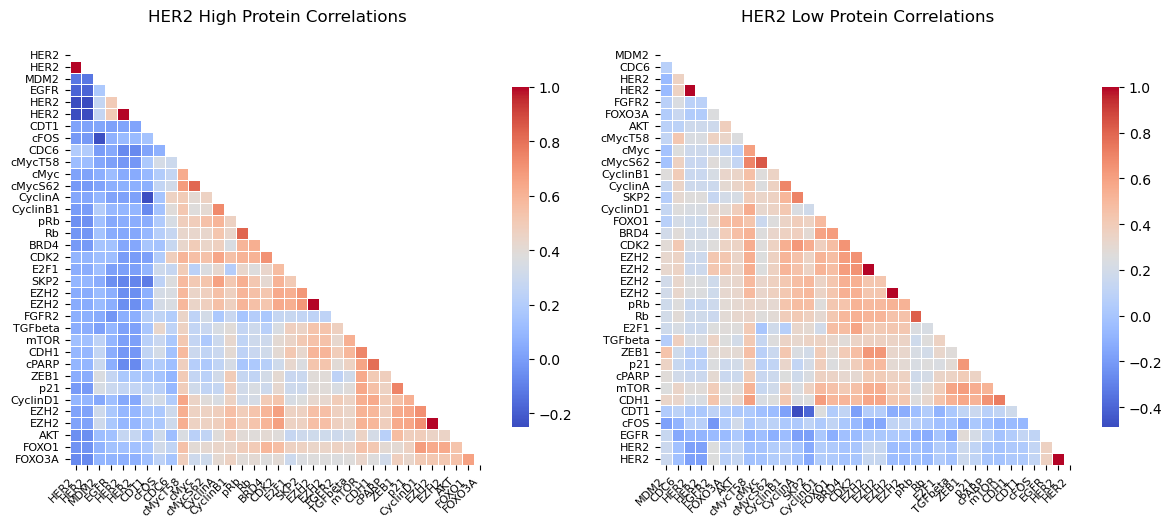

In [29]:
# Step 8: plot clustered triangular heatmaps for both groups
plt.figure(figsize=(12, 5))

# function to create clustered heatmap
def plot_clustered_heatmap(corr_matrix, title, ax):
    # hierarchical clustering
    distance_matrix = 1 - corr_matrix
    Z = linkage(squareform(distance_matrix.values, checks=False), method='average')
    
    # reorder the matrix according to the clustering result
    dendro = dendrogram(Z, labels=corr_matrix.index, no_plot=True)
    reordered_matrix = corr_matrix.iloc[dendro['leaves'], dendro['leaves']]
    
    # mask the upper triangle
    mask = np.triu(np.ones_like(reordered_matrix, dtype=bool))
    
    # plot the heatmap
    sns.heatmap(
        reordered_matrix,
        cmap='coolwarm',
        mask=mask,
        annot=False,
        linewidths=0.5,
        square=True,
        xticklabels=True,
        yticklabels=True,
        cbar_kws={"shrink": 0.8},
        ax=ax
    )
    
    # adjust labels
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right', fontsize=8)
    ax.set_yticklabels(ax.get_yticklabels(), fontsize=8)
    ax.set_title(title, pad=20)

# create subplots
ax1 = plt.subplot(1, 2, 1)
ax2 = plt.subplot(1, 2, 2)

# plot heatmaps
plot_clustered_heatmap(corr_high, 'HER2 High Protein Correlations', ax1)
plot_clustered_heatmap(corr_low, 'HER2 Low Protein Correlations', ax2)

plt.tight_layout()
plt.show()

In [76]:
# I think this heatmaps overall look good but I might make them a bit larger so that the protein names are not on 
# top of eachother [MHM]
# also I understand not using the full names for each protein as it makes it harder to read, but also I think the 
# full names are important because right now the four EZH2's on the HER2 low map might be confusing for a reader [MHM]

<Figure size 1200x1000 with 0 Axes>

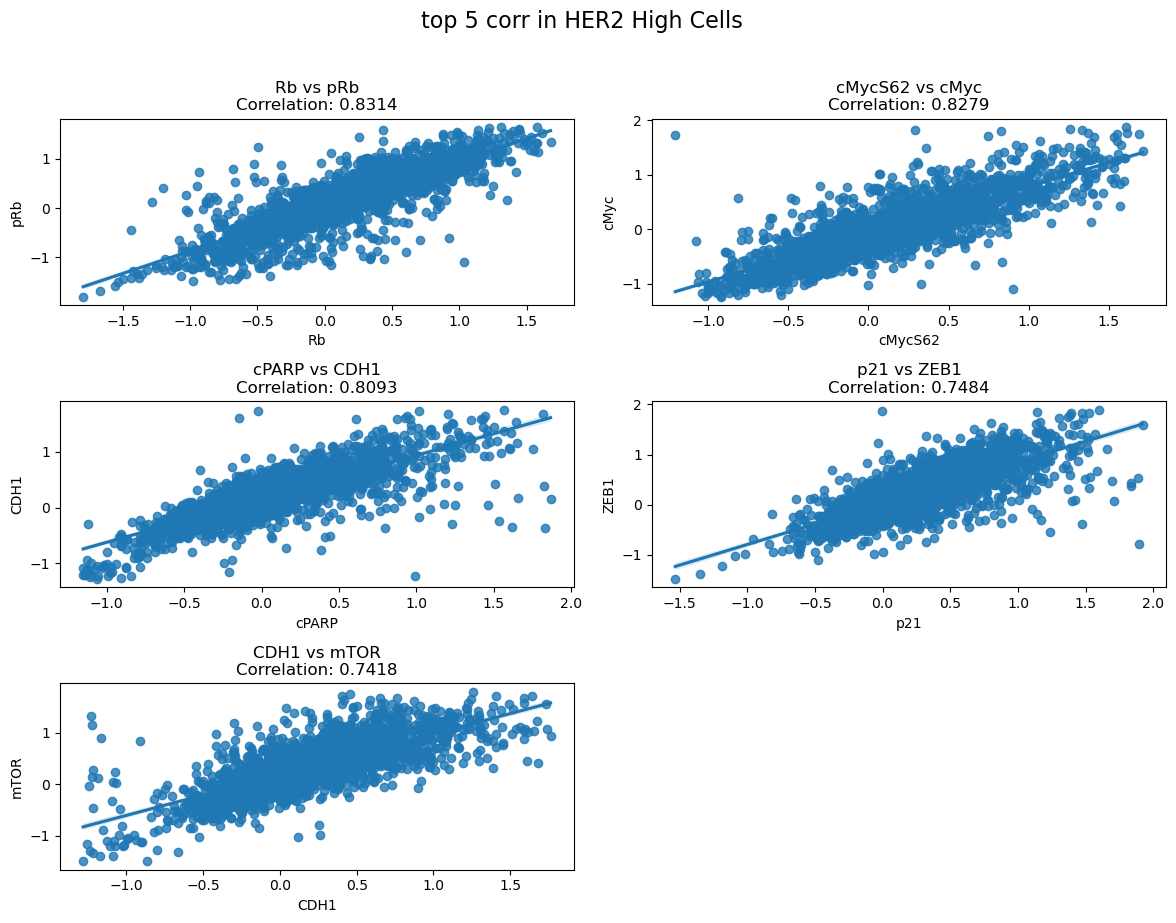

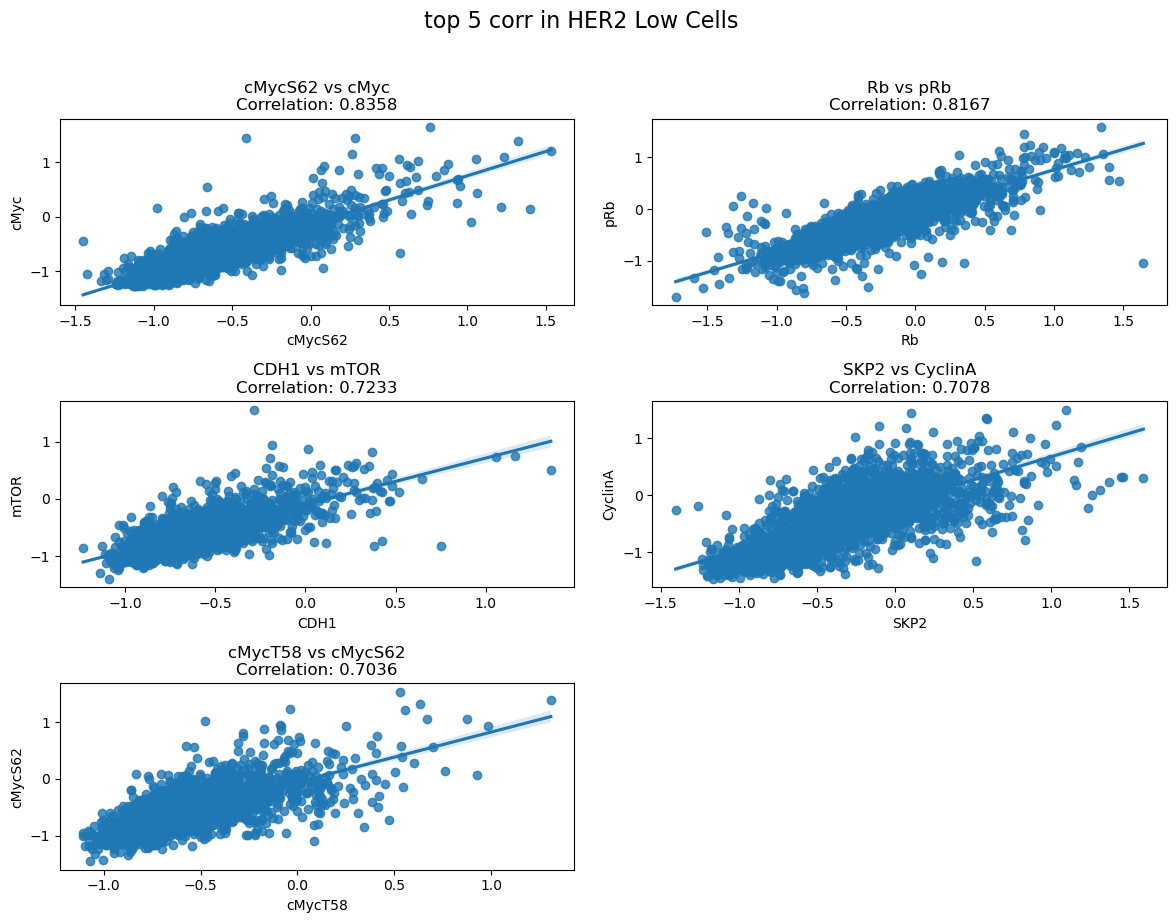

In [78]:
# Step 9: visualize the top 5 correlations for each group
plt.figure(figsize=(12, 10))

# fn to create scatter plots for top correlations
def plot_top_correlations(data, top_corrs, title, ncols=2):
    nrows = (len(top_corrs) + ncols - 1) // ncols
    fig, axes = plt.subplots(nrows, ncols, figsize=(12, 3*nrows))
    fig.suptitle(title, fontsize=16, y=1.02)
    
    # flatten axes array given conditions 
    if nrows > 1:
        axes = axes.flatten()
    elif ncols == 1:
        axes = [axes]
    
    for i, ((protein1, protein2), corr) in enumerate(top_corrs.items()):
        if i < len(axes):
            ax = axes[i]
            sns.regplot(x=protein1, y=protein2, data=data, ax=ax)
            ax.set_title(f"{protein1} vs {protein2}\nCorrelation: {corr:.4f}")
            ax.set_xlabel(protein1)
            ax.set_ylabel(protein2)
    
    # hide the unused subplots
    for j in range(len(top_corrs), len(axes)):
        axes[j].axis('off')
    
    plt.tight_layout()
    return fig

# plot top correlations for high HER2 group
high_fig = plot_top_correlations(data_high, top_corr_high, 'top 5 corr in HER2 High Cells')

# plot top correlations for low HER2 group
low_fig = plot_top_correlations(data_low, top_corr_low, 'top 5 corr in HER2 Low Cells')

In [82]:
# Maybe make the dots a little smaller so they are less blob-like [MHM]
# maybe make the line a different color so it is easier to follow [MHM]

In [86]:
# Step 10: summary table comparing the two groups
summary_data = []

# add high HER2 correlations
for (protein1, protein2), corr in top_corr_high.items():
    in_low = (protein1, protein2) in top_corr_low or (protein2, protein1) in top_corr_low
    summary_data.append({
        'Protein Pair': f"{protein1} - {protein2}",
        'HER2 Group': 'High',
        'Correlation': corr,
        'In Both Groups': 'Yes' if in_low else 'No'
    })

# add low HER2 correlations
for (protein1, protein2), corr in top_corr_low.items():
    in_high = (protein1, protein2) in top_corr_high or (protein2, protein1) in top_corr_high
    # only add if not already added (to avoid duplicates)
    if not ((protein1, protein2) in top_corr_high or (protein2, protein1) in top_corr_high):
        summary_data.append({
            'Protein Pair': f"{protein1} - {protein2}",
            'HER2 Group': 'Low',
            'Correlation': corr,
            'In Both Groups': 'Yes' if in_high else 'No'
        })

# create summary df
summary_df = pd.DataFrame(summary_data)
print("\nsummary of top Correlations between iterations:")
print(summary_df)


summary of top Correlations between iterations:
        Protein Pair HER2 Group  Correlation In Both Groups
0           Rb - pRb       High     0.831424            Yes
1     cMycS62 - cMyc       High     0.827878            Yes
2       cPARP - CDH1       High     0.809296             No
3         p21 - ZEB1       High     0.748371             No
4        CDH1 - mTOR       High     0.741781            Yes
5     SKP2 - CyclinA        Low     0.707812             No
6  cMycT58 - cMycS62        Low     0.703647             No


In [88]:
# summary table looks good and easily readable [MHM]

In [90]:
# Step 11: for any overlapping pairs, calculate the difference in correlation
if overlap_pairs:
    print("\ndifference in correlation for overlapping pairs:")
    for pair in overlap_pairs:
        corr_diff = abs(corr_high.loc[pair[0], pair[1]] - corr_low.loc[pair[0], pair[1]])
        print(f"{pair[0]} - {pair[1]}: {corr_diff:.4f}")


difference in correlation for overlapping pairs:
CDH1 - mTOR: 0.0185
cMyc - cMycS62: 0.0080
Rb - pRb: 0.0147


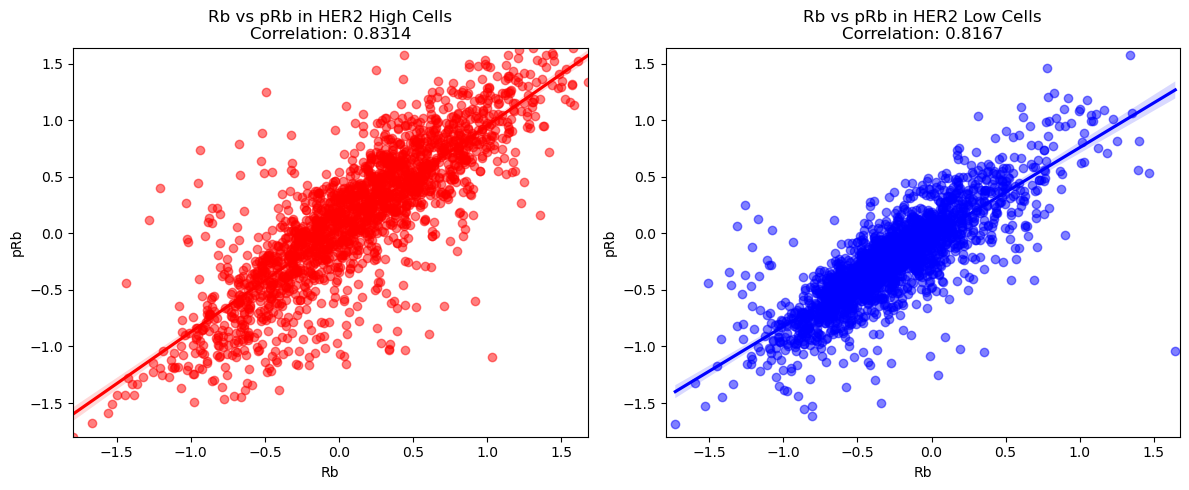

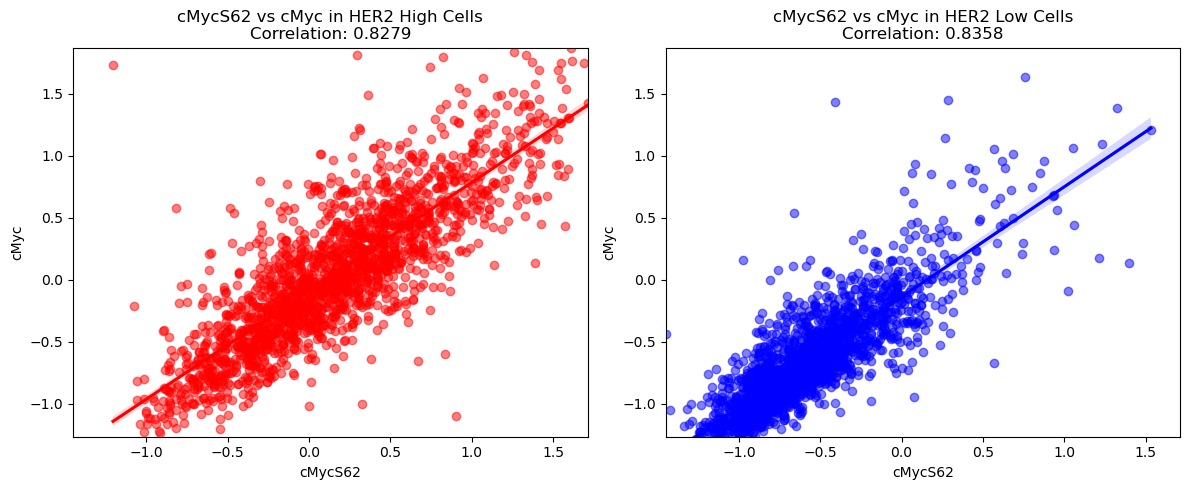

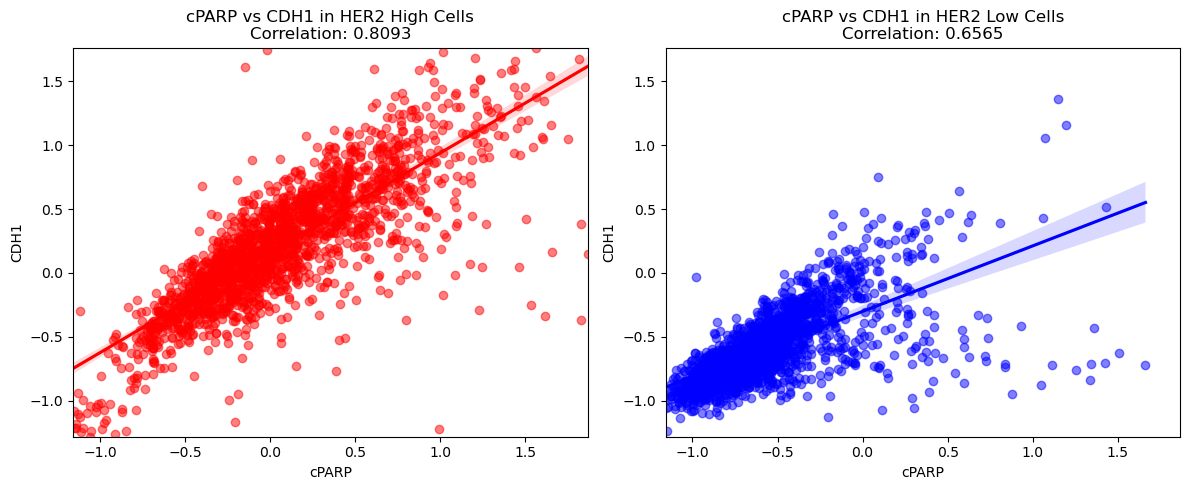

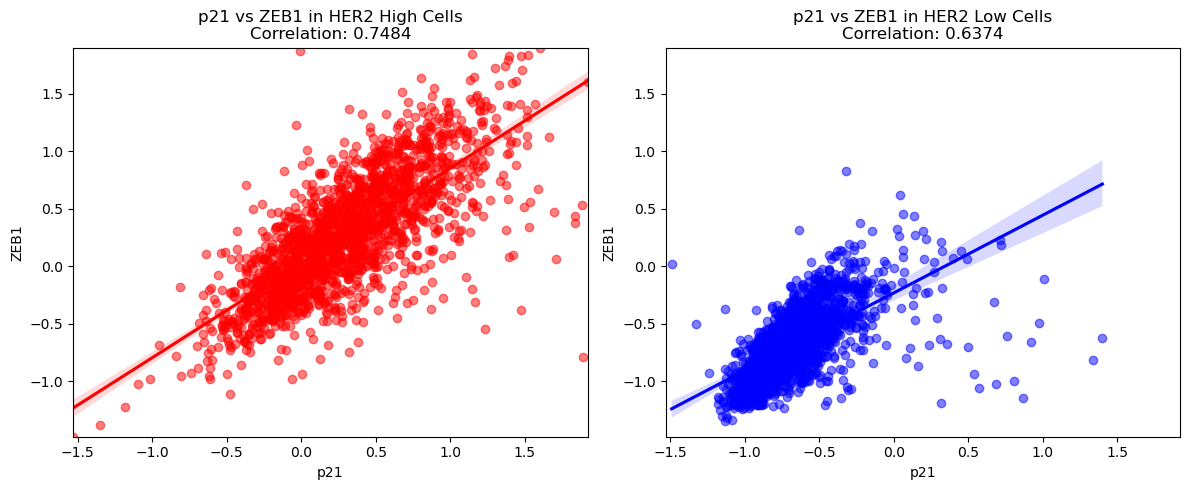

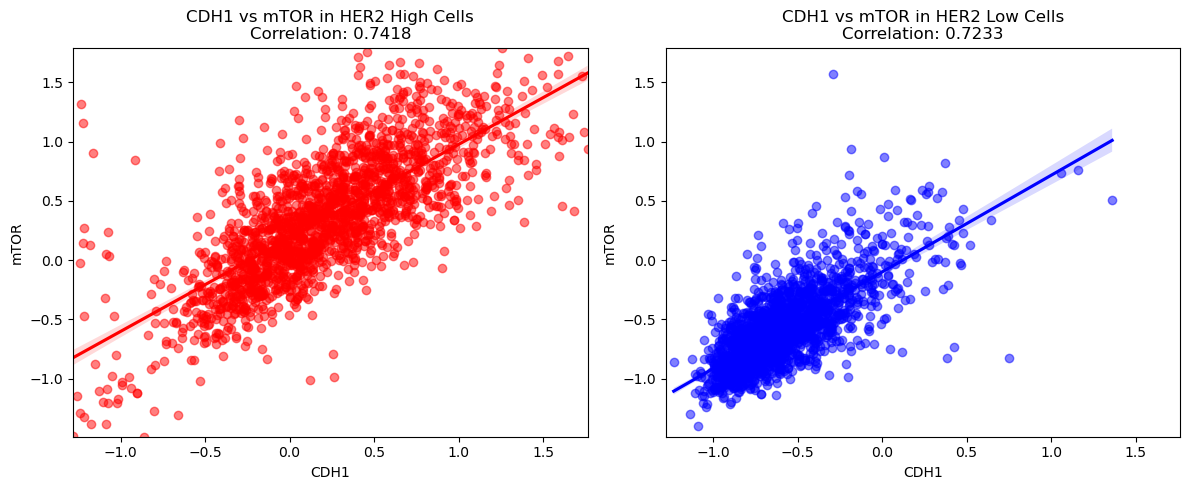


plots have been created in the 'plots' directory:
- Rb_pRb_comparison.png
- cMycS62_cMyc_comparison.png
- cPARP_CDH1_comparison.png
- p21_ZEB1_comparison.png
- CDH1_mTOR_comparison.png


In [92]:
# create plots comparing correlations between HER2 high and low cells for final objective from 3/20 discussion
# command only if objective does not exist
if not os.path.exists('plots'):
    os.makedirs('plots')

# established protein correlations
high_pairs = [
    ('Rb', 'pRb'),         # first correlation in high HER2
    ('cMycS62', 'cMyc'),   # second highest in high HER2
    ('cPARP', 'CDH1'),     # third highest in high HER2
    ('p21', 'ZEB1'),       # fourth highest in high HER2
    ('CDH1', 'mTOR')       # fifth highest in high HER2
]

# create a figure for each protein pair with side-by-side comparison
for protein1, protein2 in high_pairs:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    
    # plot for HER2 high cells
    sns.regplot(x=protein1, y=protein2, data=data_high, ax=ax1, 
                scatter_kws={'alpha':0.5}, color='red')
    corr_h = corr_high.loc[protein1, protein2]
    ax1.set_title(f"{protein1} vs {protein2} in HER2 High Cells\nCorrelation: {corr_h:.4f}")
    
    # plot for HER2 low cells
    sns.regplot(x=protein1, y=protein2, data=data_low, ax=ax2, 
                scatter_kws={'alpha':0.5}, color='blue')
    corr_l = corr_low.loc[protein1, protein2]
    ax2.set_title(f"{protein1} vs {protein2} in HER2 Low Cells\nCorrelation: {corr_l:.4f}")
    
    # set identical axes limits for fair comparison
    x_min = min(data_high[protein1].min(), data_low[protein1].min())
    x_max = max(data_high[protein1].max(), data_low[protein1].max())
    y_min = min(data_high[protein2].min(), data_low[protein2].min())
    y_max = max(data_high[protein2].max(), data_low[protein2].max())
    
    ax1.set_xlim(x_min, x_max)
    ax1.set_ylim(y_min, y_max)
    ax2.set_xlim(x_min, x_max)
    ax2.set_ylim(y_min, y_max)
    
    plt.tight_layout()
    
    # save the plot
    filename = f"plots/{protein1}_{protein2}_comparison.png"
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    
    # display the plot
    plt.show()

print("\nplots have been created in the 'plots' directory:")
for protein1, protein2 in high_pairs:
    print(f"- {protein1}_{protein2}_comparison.png")

# visually examine how the relationship between these protein pairs differs between HER2 high and low cells.

In [94]:
# same notes as above here [MHM]

In [96]:
# add enhanced plot as well to complete anlysis

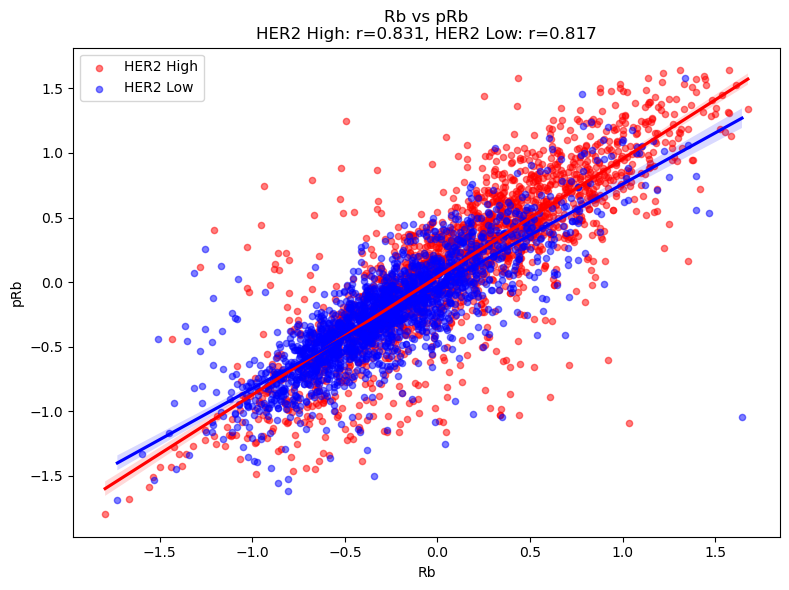

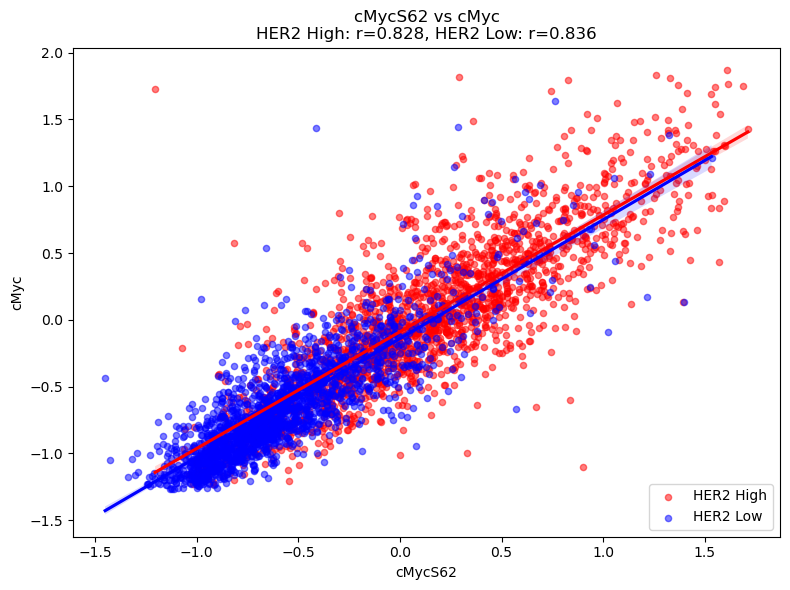

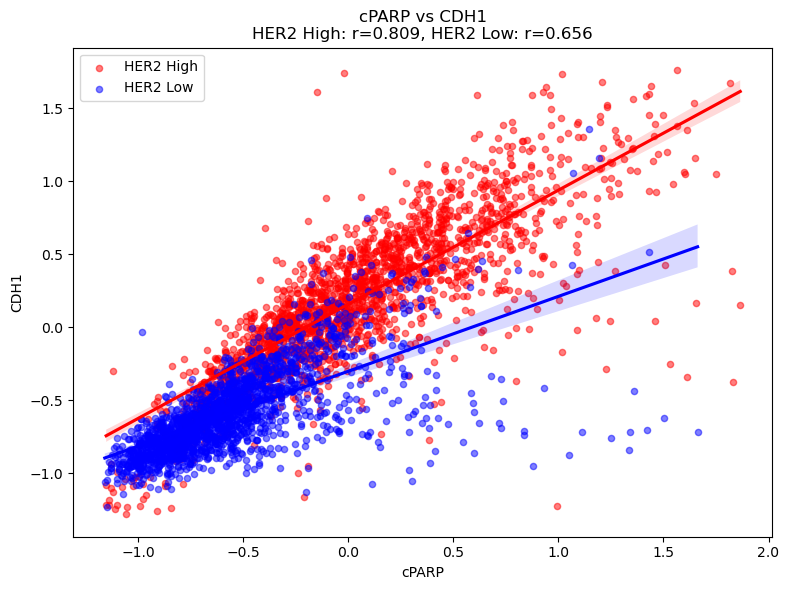

Created combined plots for the following protein pairs:
- Rb vs pRb
- cMycS62 vs cMyc
- cPARP vs CDH1


In [98]:
# extra plot work to visualize her2 top iterations (top 3) in her2 low just to see what it looks like, are there inverse trends

# define the protein pairs to analyze (top 3 from HER2 high cells)
protein_pairs = [
    ('Rb', 'pRb'),         # highest correlation in HER2 high
    ('cMycS62', 'cMyc'),   # second highest in HER2 high
    ('cPARP', 'CDH1')      # third highest in HER2 high
]

# create a figure for each protein pair
for protein1, protein2 in protein_pairs:
    fig, ax = plt.subplots(figsize=(8, 6))
    
    # plot data from HER2 high cells
    sns.regplot(x=protein1, y=protein2, data=data_high, ax=ax, 
                scatter_kws={'alpha':0.5, 'color':'red', 's':20}, 
                line_kws={'color':'red'}, label='HER2 High')
    
    # plot data from HER2 low cells on the SAME plot
    sns.regplot(x=protein1, y=protein2, data=data_low, ax=ax, 
                scatter_kws={'alpha':0.5, 'color':'blue', 's':20}, 
                line_kws={'color':'blue'}, label='HER2 Low')
    
    # add correlation values to the title
    corr_high_val = corr_high.loc[protein1, protein2]
    corr_low_val = corr_low.loc[protein1, protein2]
    ax.set_title(f"{protein1} vs {protein2}\nHER2 High: r={corr_high_val:.3f}, HER2 Low: r={corr_low_val:.3f}")
    
    # add legend and labels
    ax.legend()
    ax.set_xlabel(protein1)
    ax.set_ylabel(protein2)
    
    plt.tight_layout()
    
    # save the figure
    filename = f"plots/{protein1}_{protein2}_same_plot_comparison.png"
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    
    # show the figure
    plt.show()

print("Created combined plots for the following protein pairs:")
for protein1, protein2 in protein_pairs:
    print(f"- {protein1} vs {protein2}")

In [ ]:
# maybe add slightly more descriptive axis labels here and similar plots above [MHM]

In [ ]:
'''
Final comments:

code correctness - excellent
readability - good
code efficiency - excellent
documentation - excellent

[MHM]
'''
